In [ ]:
!pip install torch
!pip install transformers
!pip install datasets

**Step 1,2,3**
Data Preprocessing, Model Implementation and Model Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

model_name = 'prajjwal1/bert-small'
batch_size = 16
num_epochs = 3
learning_rate = 2e-5

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preprocess(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze()

def train(model, optimizer, criterion, data_loader):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    return total_loss / total_samples, correct / total_samples

def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)

            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    return accuracy, precision, recall, f1

# loading yelp datset and selecting first 1000 points
dataset = load_dataset("yelp_review_full")
dataset = dataset['train'].select(range(1000))

texts = dataset["text"]
labels = dataset["label"]

input_ids, attention_masks = preprocess(texts)
labels = torch.tensor(labels)


dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, criterion, data_loader)
    accuracy, precision, recall, f1 = evaluate(model, data_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}")
    print(f"Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-Score: {f1:.4f}")
    print()


Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
Train Loss: 0.0990 Train Acc: 0.2680
Accuracy: 0.4440 Precision: 0.4854 Recall: 0.4440 F1-Score: 0.4265

Epoch 2/3
Train Loss: 0.0889 Train Acc: 0.4250
Accuracy: 0.5520 Precision: 0.5573 Recall: 0.5520 F1-Score: 0.5389

Epoch 3/3
Train Loss: 0.0776 Train Acc: 0.5340
Accuracy: 0.6730 Precision: 0.6772 Recall: 0.6730 F1-Score: 0.6649



**Step 4** Model Interpretation and vizualization with word cloud

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

  0%|          | 0/2 [00:00<?, ?it/s]

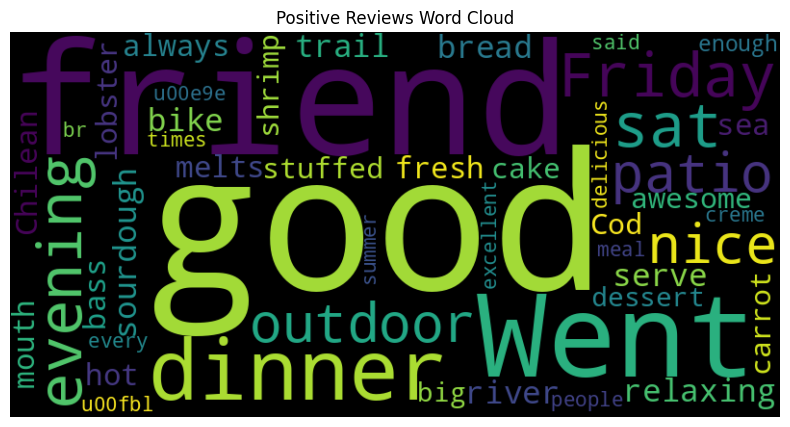

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

modName = 'prajjwal1/bert-small'

model = AutoModelForSequenceClassification.from_pretrained(modName, num_labels=5)
tokenizer = AutoTokenizer.from_pretrained(modName)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preprocess(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze()

# selecting first 1000 points
dataset = load_dataset("yelp_review_full")
dataset = dataset['train'].select(range(500))
labels = dataset["label"]
texts = dataset["text"]

input_ids, attention_masks = preprocess(texts)

labels = torch.tensor(labels)

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_masks)
logits = outputs.logits

predLabels = torch.argmax(logits, dim=1)
predLabels = predLabels.cpu().numpy()

posReviews = [text for text, label in zip(texts, predLabels) if label == 2]
cloud = WordCloud(width=800, height=400).generate(" ".join(posReviews))

plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()


**Step 5** Model comparision with Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset

# load logistic regressino model
vectorizer = TfidfVectorizer()
logreg_model = LogisticRegression()

# select firsst 5000 points from yelp dataset
dataset = load_dataset("yelp_review_full")
dataset = dataset['train'].select(range(1000))

labels = dataset["label"]
texts = dataset["text"]

features = vectorizer.fit_transform(texts)
logreg_model.fit(features, labels)
logregPred = logreg_model.predict(features)

accuracy = accuracy_score(labels, logregPred)
precision = precision_score(labels, logregPred, average='weighted')
recall = recall_score(labels, logregPred, average='weighted')
f1 = f1_score(labels, logregPred, average='weighted')

print("Traditional Machine Learning Model (Logistic Regression):")
print(f"Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-Score: {f1:.4f}")


  0%|          | 0/2 [00:00<?, ?it/s]

Traditional Machine Learning Model (Logistic Regression):
Accuracy: 0.9570 Precision: 0.9593 Recall: 0.9570 F1-Score: 0.9572
